importing some of the standard libraries

In [1]:
import pandas as pd
from pandas.io.json import build_table_schema
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import scipy as sp
import os
import xgboost as xgb
import visualization as vis
import matplotlib.pyplot as plt
import matplotlib
import plot_improper_processing as plt_imp
import time
from operator import itemgetter
import seaborn as sns
%matplotlib inline

DIR_PATH = './'

Loading the data and printing out the length of the columns 
This includes all the columns after cleaning and imputation. (Thanks Chase)

In [2]:
traindata  = pd.read_csv("./data/clean_train_only_complete_cols_chase.csv")
testdata = pd.read_csv("./data/clean_test_only_complete_cols_chase.csv")
print len(traindata.columns.values)
print 40 * '*'
print len(testdata.columns.values)

247
****************************************
246


some feature engineering

In [3]:
traindata.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,kitch_sq,product_type,sub_area,area_m,...,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,okurg_district,price_full
0,1,2011-08-20,43.0,28.120000,4.0,5.0,4.962353,Investment,Bibirevo,6.407578e+06,...,0,13,22,1,0,52,4,5850000,North Eastern,136046.511628
1,2,2011-08-23,34.0,19.000000,3.0,9.0,5.066667,Investment,Nagatinskij Zaton,9.589337e+06,...,0,15,29,1,10,66,14,6000000,Southern,176470.588235
2,3,2011-08-27,43.0,29.000000,2.0,5.0,7.327128,Investment,Tekstil'shhiki,4.808270e+06,...,0,11,27,0,4,67,10,5700000,South Eastern,132558.139535
3,4,2011-09-01,89.0,67.522222,9.0,17.0,18.005926,Investment,Mitino,1.258354e+07,...,1,4,4,0,0,26,3,13100000,North Western,147191.011236
4,5,2011-09-05,77.0,70.777778,4.0,8.0,14.155556,Investment,Basmannoe,8.398461e+06,...,17,135,236,2,91,195,14,16331452,Central,212096.779221


In [4]:
g = traindata.columns.to_series().groupby(traindata.dtypes).groups
g# The year is a float and maybe it should be a categorical variable. 

{dtype('int64'): Index([u'id', u'raion_popul', u'children_preschool',
        u'preschool_education_centers_raion', u'children_school',
        u'school_education_centers_raion',
        u'school_education_centers_top_20_raion', u'healthcare_centers_raion',
        u'university_top_20_raion', u'sport_objects_raion',
        ...
        u'cafe_count_5000_price_2500', u'cafe_count_5000_price_4000',
        u'cafe_count_5000_price_high', u'big_church_count_5000',
        u'church_count_5000', u'mosque_count_5000', u'leisure_count_5000',
        u'sport_count_5000', u'market_count_5000', u'price_doc'],
       dtype='object', length=156),
 dtype('float64'): Index([u'full_sq', u'life_sq', u'floor', u'max_floor', u'kitch_sq', u'area_m',
        u'green_zone_part', u'indust_part', u'metro_min_avto', u'metro_km_avto',
        u'kindergarten_km', u'school_km', u'park_km', u'green_zone_km',
        u'industrial_km', u'water_treatment_km', u'cemetery_km',
        u'incineration_km', u'railroad_sta

In [5]:
traindata.loc[:, 'log_price_doc'] = np.log(traindata['price_doc'] + 1)

traindata.loc[:, 'year'] =  traindata.loc[:,'timestamp'].apply(lambda x: x[0:4])
traindata.loc[:, 'month'] =  traindata.loc[:, 'timestamp'].apply(lambda x: x[5:7])
testdata.loc[:, 'year'] = testdata.loc[:, 'timestamp'].apply(lambda x: x[0:4])
testdata.loc[:, 'month'] = testdata.loc[:, 'timestamp'].apply(lambda x: x[0:4])

In [6]:
from sklearn import model_selection, preprocessing
for f in testdata.columns:
    if testdata[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(testdata[f].values.astype('str')))
        testdata[f] = lbl.transform(list(testdata[f].values.astype('str')))

timestamp
product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
okurg_district
year
month


In [7]:
from sklearn import model_selection, preprocessing
for f in traindata.columns:
    if traindata[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(traindata[f].values.astype('str')))
        traindata[f] = lbl.transform(list(traindata[f].values.astype('str')))

timestamp
product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
okurg_district
year
month


From the EDA we are going to only examine the top 22 columns and the target parameter is the
log_price_doc

In [8]:
feature_cols = ['full_sq', 'life_sq', 'floor', 'max_floor', 'kitch_sq',
               'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km',
               'metro_min_avto', 'railroad_km','public_transport_station_km','sub_area',
               'swim_pool_km','cemetery_km','public_healthcare_km','fitness_km','radiation_km',
               'year','month']
target_column  = ['log_price_doc']

Filter out only the columns of interest

In [9]:
X_data =  traindata[feature_cols]
y_data =  traindata[target_column]
X_testdata = testdata[feature_cols] # note this only for Kaggle and there is no y_testdata


In [10]:
X_train = X_data.values
Y_train = y_data.values
X_test = X_testdata.values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(29096, 21)
(29096, 1)
(7662, 21)


## Decision Tree Models 

In [11]:
from sklearn.tree import DecisionTreeRegressor 
tree = DecisionTreeRegressor().fit(X_train, Y_train)

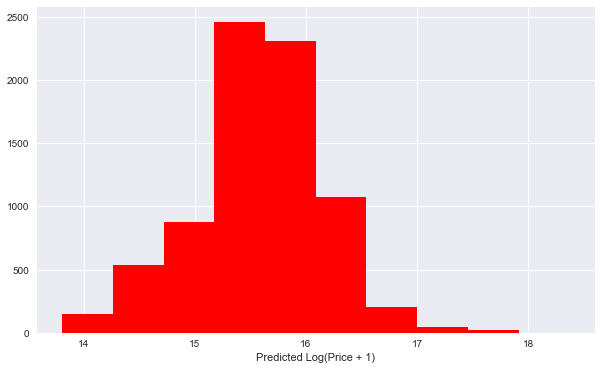

In [12]:
log_y_test = tree.predict(X_test)

fig, ax = plt.subplots(figsize=(10,6))
rects = ax.hist(log_y_test, color ='r')
ax.set_xlabel("Predicted Log(Price + 1)")
ax.set_title("")
plt.show()


In [13]:
print("The R^2 on the training set:  {:.6f}".format(tree.score(X_train, Y_train)))

The R^2 on the training set:  0.999878


This is a single Decision Tree and we know that we are overfitting. And since this is model is not going to produce a high accuracy we shall split the training data to evaluate the model.

In [14]:
xtree_train, xtree_test, ytree_train, ytree_test = model_selection.train_test_split(X_train,Y_train,random_state=42)

In [15]:
tree = DecisionTreeRegressor().fit(xtree_train, ytree_train)

print("Accuracy on training set {:.3f}".format(tree.score(xtree_train, ytree_train)))
print("Accuracy on test set {:.3f}".format(tree.score(xtree_test, ytree_test)))
print("The severe overfitting of the unrestrained Decision Tree!!")

Accuracy on training set 1.000
Accuracy on test set 0.216
The severe overfitting of the unrestrained Decision Tree!!


In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
def report(grid_scores, n_top=3):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

    return top_scores[0].parameters

In [18]:
def run_gridsearch(X, y, clf, param_grid, cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets 
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv, n_jobs = 3)
    start = time.time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time.time() - start,
                len(grid_search.grid_scores_)))

    top_params = report(grid_search.grid_scores_, 3)
    return  top_params, grid_search

In [19]:
print("-- Grid Parameter Search via 5-fold CV")

# set of parameters to test
param_grid = {"min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

dt = DecisionTreeRegressor()
ts_gs, dt_grid= run_gridsearch(xtree_train, ytree_train, dt, param_grid, cv=5)

-- Grid Parameter Search via 5-fold CV

GridSearchCV took 48.76 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.537 (std: 0.006)
Parameters: {'min_samples_split': 10, 'max_leaf_nodes': None, 'max_depth': 10, 'min_samples_leaf': 10}

Model with rank: 2
Mean validation score: 0.537 (std: 0.006)
Parameters: {'min_samples_split': 20, 'max_leaf_nodes': None, 'max_depth': 10, 'min_samples_leaf': 10}

Model with rank: 3
Mean validation score: 0.537 (std: 0.006)
Parameters: {'min_samples_split': 2, 'max_leaf_nodes': None, 'max_depth': 10, 'min_samples_leaf': 10}



/Users/yogadude/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/yogadude/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [20]:
print("\n-- Best Parameters:")
for k, v in ts_gs.items():
    print("parameter: {:<20s} setting: {}".format(k, v))


-- Best Parameters:
parameter: min_samples_split    setting: 10
parameter: max_leaf_nodes       setting: None
parameter: max_depth            setting: 10
parameter: min_samples_leaf     setting: 10


In [21]:
best_tree = DecisionTreeRegressor(min_samples_split = 20, max_depth=10,min_samples_leaf=10).fit(xtree_train, ytree_train)

print("Accuracy on training set {:.3f}".format(best_tree.score(xtree_train, ytree_train)))
print("Accuracy on test set {:.3f}".format(best_tree.score(xtree_test, ytree_test)))
print("No longer overfitting of the Decision Tree!!")

Accuracy on training set 0.628
Accuracy on test set 0.568
No longer overfitting of the Decision Tree!!


In [53]:
dt_grid.cv_results_['mean_test_score'].reshape(3,4,3,4)
# sns.heatmap(rf_grid.cv_results_['mean_test_score'].reshape(10,11),
#             xticklabels=param_grid["n_estimators"], yticklabels=param_grid["max_features"])

array([[[[ 0.2031854 ,  0.3062827 ,  0.36373875,  0.39715715],
         [ 0.39867576,  0.44529557,  0.47272451,  0.47246823],
         [ 0.47236833,  0.3879964 ,  0.3879964 ,  0.3879964 ]],

        [[ 0.3879964 ,  0.3879964 ,  0.3879964 ,  0.3879964 ],
         [ 0.3879964 ,  0.3879964 ,  0.46895246,  0.46895246],
         [ 0.46895246,  0.46895246,  0.46895246,  0.46895246]],

        [[ 0.46895246,  0.46895246,  0.46895246,  0.50879353],
         [ 0.50879353,  0.50879353,  0.50879353,  0.50879353],
         [ 0.50879353,  0.50879353,  0.50879353,  0.50879353]],

        [[ 0.34882495,  0.34882495,  0.34882495,  0.34882495],
         [ 0.34882495,  0.34882495,  0.34882495,  0.34882495],
         [ 0.34882495,  0.3879964 ,  0.3879964 ,  0.3879964 ]]],


       [[[ 0.3879964 ,  0.3879964 ,  0.3879964 ,  0.3879964 ],
         [ 0.3879964 ,  0.3879964 ,  0.44389983,  0.44389983],
         [ 0.44389983,  0.44389983,  0.44389983,  0.44389983]],

        [[ 0.44389983,  0.44389983,  0.4438

Random Forest implementation 

In [22]:
from sklearn.ensemble import RandomForestRegressor
# We start with using the default parameters 
forest = RandomForestRegressor()
forest.fit(xtree_train, ytree_train.ravel())
print("Accuracy on training set {:.3f}".format(forest.score(xtree_train, ytree_train)))
print("Accuracy on test set {:.3f}".format(forest.score(xtree_test, ytree_test)))
print("Also overfitting of the unrestrained Random Forest!!")

Accuracy on training set 0.922
Accuracy on test set 0.581
Also overfitting of the unrestrained Random Forest!!


In [23]:
blah = RandomForestRegressor()
blah

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [61]:
print("-- Grid Parameter Search via 5-fold CV")

n_estimate = list(range(400, 950,50))
n_estimate =  n_estimate[1:]
maxlist_features = list(range(5,xtree_train.shape[1]))
# set of parameters to test
param_grid = {"n_estimators": n_estimate,
              "max_features": maxlist_features
              }
rf = RandomForestRegressor()
ts_gs, rf_grid = run_gridsearch(xtree_train, ytree_train.ravel(), rf, param_grid, cv=5)

-- Grid Parameter Search via 5-fold CV

GridSearchCV took 45016.63 seconds for 160 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.607 (std: 0.015)
Parameters: {'max_features': 5, 'n_estimators': 900}

Model with rank: 2
Mean validation score: 0.607 (std: 0.016)
Parameters: {'max_features': 5, 'n_estimators': 700}

Model with rank: 3
Mean validation score: 0.607 (std: 0.015)
Parameters: {'max_features': 5, 'n_estimators': 650}



/Users/yogadude/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/yogadude/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [65]:
print len(n_estimate)
print len(maxlist_features)

10
16


In [62]:
print("\n-- Best Parameters:")
for k, v in ts_gs.items():
    print("parameter: {:<20s} setting: {}".format(k, v))


-- Best Parameters:
parameter: max_features         setting: 5
parameter: n_estimators         setting: 900


In [66]:
best_rf = RandomForestRegressor(max_features = 5, n_estimators = 900).fit(xtree_train, ytree_train.ravel())

print("Accuracy on training set {:.3f}".format(best_rf.score(xtree_train, ytree_train)))
print("Accuracy on test set {:.3f}".format(best_rf.score(xtree_test, ytree_test)))
print("No longer overfitting of the Random Forest, as much!!")

Accuracy on training set 0.948
Accuracy on test set 0.629
No longer overfitting of the Random Forest, as much!!


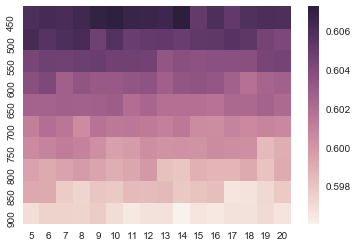

In [68]:
sns.heatmap(rf_grid.cv_results_['mean_test_score'].reshape(10,16),
            xticklabels=param_grid["max_features"], yticklabels=param_grid["n_estimators"])
plt.show()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)